# A. Data Wrangling

# 1. Purpose of This Data Science Project

The purpose of this data science project is to develop a pricing model for rents listed on rental postings. Property owners would benefit from listing their property at an appropriate price and in line with their position in the market. Owners would also benefit from insights to high-value versus low-value features.

In [1]:
pip install fuzzywuzzy


Note: you may need to restart the kernel to use updated packages.


# 2. Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.options.display.max_columns = None
import missingno as msno
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
from collections import defaultdict
from datetime import datetime
from fuzzywuzzy import process, fuzz
import itertools

C:\Users\zebin\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# 3. Objectives of This Notebook

- To determine if the data we have could be use to develop a pricing model
    - Verify that there is an appropriate target feature
    - Verify that there are potentially useful features
- Verify that there are not fundamental issues with the data

# 4. Loading Data

In [3]:
immo_data= pd.read_csv('../data/raw/immo_data.csv')

In [4]:
rentals = immo_data.copy()

# 5. Explore Data

In [5]:
rentals.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,840.0,1965.0,96107057,1.0,oil,False,Nordrhein_Westfalen,True,2.0,595.0,244,86.00,Dortmund,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.4,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,NaN,1871.0,111378734,2.0,gas,False,Rheinland_Pfalz,False,1.0,800.0,NaN,89.00,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,1300.0,2019.0,113147523,1.0,NaN,False,Sachsen,True,9.0,965.0,4,83.80,Dresden,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,NaN,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,NaN,1964.0,108890903,NaN,district_heating,False,Sachsen,False,2.0,343.0,35,58.15,Mittelsachsen_Kreis,NaN,NaN,NaN,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,False,2,other,9599,3.0,86.0,3.0,NaN,3,False,2,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,903.0,1950.0,114751222,NaN,gas,False,Bremen,False,1.0,765.0,10,84.97,Bremen,refurbished,NaN,NaN,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,False,5,apartment,28213,3.0,188.9,1.0,NaN,3,False,4,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


In [6]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

In [7]:
rentals.shape

(268850, 49)

- baseRent and totalRent are appropriate features we can use as our target.
- yearConstructed, lastRefurbish and date should be datetime datatypes

In [8]:
#Convert yearConstructed, lastRefurbish and date to datetime
rentals.yearConstructed = pd.to_datetime(rentals.yearConstructed, format = '%Y', errors = 'coerce')
rentals.lastRefurbish = pd.to_datetime(rentals.lastRefurbish, format = '%Y', errors = 'coerce')
rentals.date = pd.to_datetime(rentals.date, format = '%b%y')

In [9]:
#Verify datetime features
rentals.select_dtypes(include=[np.datetime64]).head(3)

,yearConstructed,lastRefurbish,date
0,1965-01-01,NaT,2019-05-01
1,1871-01-01,2019-01-01,2019-05-01
2,2019-01-01,NaT,2019-10-01


## 5.1 Reviewing Data Completeness

In [10]:
#To determine counts and percentage of valid entries
missing = pd.concat([rentals.isnull().sum(), rentals.isnull().mean() * 100], axis = 1)
missing.columns = ['num_mssg', 'perc_mssg']
missing.sort_values(by = 'num_mssg', ascending = False)

,num_mssg,perc_mssg
telekomHybridUploadSpeed,223830,83.254603
electricityKwhPrice,222004,82.575414
electricityBasePrice,222004,82.575414
energyEfficiencyClass,191063,71.066766
lastRefurbish,188145,69.981402
heatingCosts,183332,68.191185
noParkSpaces,175798,65.388879
petsAllowed,114573,42.615957
interiorQual,112665,41.906267
thermalChar,106506,39.615399


- Some features have many missing values. We will use only features that are over 60% complete (under 40% missing).

In [11]:
#Filter-out features with over 40% missing values
rentals = msno.nullity_filter(rentals,filter = 'top', p =0.6)

In [12]:
#Verify features have been dropped
rentals.shape

(268850, 40)

In [13]:
rentals.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,False,False,6,4.62,10.0,840.0,1965-01-01,96107057,oil,False,Nordrhein_Westfalen,True,2.0,595.0,244,86.00,Dortmund,well_kept,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.4,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,2019-05-01
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,False,True,8,3.47,10.0,NaN,1871-01-01,111378734,gas,False,Rheinland_Pfalz,False,1.0,800.0,NaN,89.00,Rhein_Pfalz_Kreis,refurbished,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,2019-05-01
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,True,True,8,2.72,2.4,1300.0,2019-01-01,113147523,NaN,False,Sachsen,True,9.0,965.0,4,83.80,Dresden,first_time_use,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,NaN,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",2019-10-01
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,False,True,9,1.53,40.0,NaN,1964-01-01,108890903,district_heating,False,Sachsen,False,2.0,343.0,35,58.15,Mittelsachsen_Kreis,NaN,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,False,2,other,9599,3.0,86.0,3.0,NaN,3,False,2,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,2019-05-01
4,Bremen,138.00,self_contained_central_heating,NaN,False,True,19,2.46,NaN,903.0,1950-01-01,114751222,gas,False,Bremen,False,1.0,765.0,10,84.97,Bremen,refurbished,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,False,5,apartment,28213,3.0,188.9,1.0,NaN,3,False,4,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,2020-02-01


# 6. Reviewing Categorical Features
    
## 6.1 Address Information
### (houseNumber, geo_bln, geo_krs, street, geo_plz, regio1, regio2,    regio3, streetPlain) 

In [14]:
rentals[['houseNumber','street', 'streetPlain', 'regio3', 'regio2','geo_krs','regio1', 'geo_bln', 'geo_plz']].head()

,houseNumber,street,streetPlain,regio3,regio2,geo_krs,regio1,geo_bln,geo_plz
0,244,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,Schüren,Dortmund,Dortmund,Nordrhein_Westfalen,Nordrhein_Westfalen,44269
1,NaN,no_information,NaN,Böhl_Iggelheim,Rhein_Pfalz_Kreis,Rhein_Pfalz_Kreis,Rheinland_Pfalz,Rheinland_Pfalz,67459
2,4,Turnerweg,Turnerweg,Äußere_Neustadt_Antonstadt,Dresden,Dresden,Sachsen,Sachsen,1097
3,35,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,Freiberg,Mittelsachsen_Kreis,Mittelsachsen_Kreis,Sachsen,Sachsen,9599
4,10,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,Neu_Schwachhausen,Bremen,Bremen,Bremen,Bremen,28213


- We notice that street seems identical to streetPlain, regio2 seems identical to geo_krs and regio1 seems identical to geo_bln
- We will review these relationships

In [15]:
#Check if there are records where regio1 is not identical to geo_bln 
(rentals["regio1"] != rentals['geo_bln']).sum() 

0

- regio1 is always equal to geo_bln. We will drop geo_bln

In [16]:
#Number of categories
rentals.regio1.nunique()

16

In [17]:
#Review category names and how many records in which they appear
rentals.regio1.value_counts()

Nordrhein_Westfalen       62863
Sachsen                   58154
Bayern                    21609
Sachsen_Anhalt            20124
Hessen                    17845
Niedersachsen             16593
Baden_Württemberg         16091
Berlin                    10406
Thüringen                  8388
Rheinland_Pfalz            8368
Brandenburg                6954
Schleswig_Holstein         6668
Mecklenburg_Vorpommern     6634
Hamburg                    3759
Bremen                     2965
Saarland                   1429
Name: regio1, dtype: int64

In [18]:
#Check if there are records where regio1 is not identical to geo_bln 
(rentals["regio2"] != rentals['geo_krs']).sum() 

0

- regio2 is always equal to geo_krs. We will drop geo_krs

In [19]:
#Number of categories
rentals.regio2.nunique()

419

In [20]:
#Review category names and how many records in which they appear
rentals.regio2.value_counts().head()

Leipzig      13723
Chemnitz     12575
Berlin       10406
Dresden       7522
Magdeburg     4860
Name: regio2, dtype: int64

In [21]:
#We can take a sample of street and streetPlain data to verify that they are identical
rentals[['street', 'streetPlain']].sample(10)

,street,streetPlain
102935,Heidestra&szlig;e,Heidestraße
8849,no_information,NaN
160980,no_information,NaN
202109,Siemensstr.,Siemensstr.
234614,no_information,NaN
200520,St.-Magnus-Stra&szlig;e,St.-Magnus-Straße
151552,no_information,NaN
61012,Ebendorfer Str.,Ebendorfer_Str.
252962,Theodor-Neubauer-Str.,Theodor-Neubauer-Str.
219011,Schwarzenbergstr.,Schwarzenbergstr.


- street and streetPlain are always identical. We will drop street

In [22]:
#Number of categories
rentals.streetPlain.nunique()

54490

In [23]:
#Review category names and how many records in which they appear
rentals.streetPlain.value_counts().head()

Hauptstraße         911
Bahnhofstraße       834
Leipziger_Straße    428
Goethestraße        406
Bahnhofstr.         401
Name: streetPlain, dtype: int64

- We note that streetPlain has a high cardinatliy

In [24]:
#Drop redundant columns
rentals.drop(columns = ['street', 'geo_bln', 'geo_krs'], axis = 1, inplace = True)

## 6.1.1 Check for Duplicated Addresses 

In [25]:
#Check for duplicates across all columns
rentals.duplicated().sum()

0

In [26]:
#Check for duplicates across the columns for address
address = ['houseNumber', 'streetPlain','regio3', 'regio2','regio1','geo_plz']
rentals.duplicated(subset = address).sum()

112031

-There are potentially 112,031 rows that have duplicated values. We will review the nature of the duplicated rows

In [27]:
duplicates = rentals[rentals.duplicated(subset = address, keep = False)]

In [28]:
duplicates.loc[:, address].sort_values(by = ['regio3', 'streetPlain']).head(10)

,houseNumber,streetPlain,regio3,regio2,regio1,geo_plz
24895,NaN,NaN,Aach,Konstanz_Kreis,Baden_Württemberg,78267
66275,NaN,NaN,Aach,Konstanz_Kreis,Baden_Württemberg,78267
230574,NaN,NaN,Aach,Konstanz_Kreis,Baden_Württemberg,78267
36397,22,Schulstraße,Aachen_Eilendorf,Aachen,Nordrhein_Westfalen,52080
86456,22,Schulstraße,Aachen_Eilendorf,Aachen,Nordrhein_Westfalen,52080
16679,358,Von-Coels-Str.,Aachen_Eilendorf,Aachen,Nordrhein_Westfalen,52080
101994,358,Von-Coels-Str.,Aachen_Eilendorf,Aachen,Nordrhein_Westfalen,52080
6134,NaN,NaN,Aachen_Eilendorf,Aachen,Nordrhein_Westfalen,52080
6237,NaN,NaN,Aachen_Eilendorf,Aachen,Nordrhein_Westfalen,52080
7521,NaN,NaN,Aachen_Eilendorf,Aachen,Nordrhein_Westfalen,52080


In [29]:
duplicates.loc[:, address].sort_values(by = ['regio3', 'streetPlain']).tail(10)

,houseNumber,streetPlain,regio3,regio2,regio1,geo_plz
75374,NaN,NaN,Ückendorf,Gelsenkirchen,Nordrhein_Westfalen,45886
81696,NaN,NaN,Ückendorf,Gelsenkirchen,Nordrhein_Westfalen,45886
96559,NaN,NaN,Ückendorf,Gelsenkirchen,Nordrhein_Westfalen,45886
205156,NaN,NaN,Ückendorf,Gelsenkirchen,Nordrhein_Westfalen,45886
90695,NaN,NaN,Ückeritz,Ostvorpommern_Kreis,Mecklenburg_Vorpommern,17459
138262,NaN,NaN,Ückeritz,Ostvorpommern_Kreis,Mecklenburg_Vorpommern,17459
157101,NaN,NaN,Ückesdorf,Bonn,Nordrhein_Westfalen,53125
157357,NaN,NaN,Ückesdorf,Bonn,Nordrhein_Westfalen,53125
5980,NaN,NaN,Ühlingen_Birkendorf,Waldshut_Kreis,Baden_Württemberg,79777
45882,NaN,NaN,Ühlingen_Birkendorf,Waldshut_Kreis,Baden_Württemberg,79777


- We notice that the houseNumber and street information has many missing values that may contribute to missing duplicates. Let's review duplicates that do not have missing houseNumber and streetPlain information. 

In [30]:
duplicates.loc[rentals.houseNumber.notnull() & rentals.streetPlain.notnull()].sort_values(by = ['regio3', 'streetPlain']).tail()

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,firingTypes,hasKitchen,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,condition,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,date
189274,Nordrhein_Westfalen,117.0,NaN,ONE_YEAR_FREE,False,True,8,2.05,40.0,648.0,1961-01-01,109002173,oil,False,True,2.0,414.0,206,78.0,well_kept,Ückendorfer_Straße,False,3,apartment,45886,2.0,205.9,4.0,4.0,2,False,3,Gelsenkirchen,Ückendorf,Das 4-stöckige Wohnhaus wurde 1961 erbaut - Im...,Es handelt sich hier um eine sehr großzügig ge...,2020-02-01
223515,Nordrhein_Westfalen,79.0,NaN,ONE_YEAR_FREE,False,True,7,2.07,40.0,438.0,1961-01-01,109001556,oil,False,True,2.0,280.0,206,52.8,well_kept,Ückendorfer_Straße,False,1,apartment,45886,2.0,205.9,4.0,NaN,2,False,2,Gelsenkirchen,Ückendorf,Das 4-stöckige Wohnhaus wurde 1961 erbaut - In...,Die 2-Zimmer-Wohnung verteilt sich auf knapp 5...,2019-10-01
257856,Nordrhein_Westfalen,70.0,central_heating,NaN,False,False,3,2.84,NaN,380.0,NaT,110023110,gas,False,False,NaN,240.0,26,40.0,NaN,Ückendorfer_Straße,False,1,NaN,45886,1.0,NaN,0.0,3.0,1,False,1,Gelsenkirchen,Ückendorf,Single-Wohnung im 2. und 3. Obergeschoss eines...,NaN,2019-05-01
90795,Nordrhein_Westfalen,79.0,central_heating,ONE_YEAR_FREE,False,True,7,1.79,40.0,438.0,1961-01-01,106938799,oil,False,True,2.0,280.0,206,52.8,well_kept,Ückendorfer_Straße_,False,1,NaN,45886,2.0,205.9,4.0,4.0,2,False,2,Gelsenkirchen,Ückendorf,Das 4-stöckige Wohnhaus wurde 1961 erbaut - In...,Die 2-Zimmer-Wohnung verteilt sich auf knapp 5...,2018-09-01
197250,Nordrhein_Westfalen,100.5,central_heating,ONE_YEAR_FREE,False,True,7,1.79,40.0,556.0,1961-01-01,106937105,oil,False,True,2.0,355.0,206,67.0,well_kept,Ückendorfer_Straße_,False,2,NaN,45886,2.0,205.9,0.0,4.0,2,False,3,Gelsenkirchen,Ückendorf,Das 4-stöckige Wohnhaus wurde 1961 erbaut - Im...,Die Wohnung erstreckt sich mit ihren 2 Zimmern...,2018-09-01


In [31]:
duplicates.loc[rentals.houseNumber.notnull() & rentals.streetPlain.notnull()].sort_values(by = ['regio3', 'streetPlain']).head()

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,firingTypes,hasKitchen,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,condition,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,date
36397,Nordrhein_Westfalen,155.0,heat_pump,NaN,False,True,11,2.35,NaN,790.0,2014-01-01,115542634,NaN,False,True,8.0,570.0,22,47.00,mint_condition,Schulstraße,True,4,ground_floor,52080,2.0,32.0,0.0,3.0,2,False,2,Aachen,Aachen_Eilendorf,Im Erdgeschoss eines erst 2014 errichteten seh...,- Aufzug\n- Terrasse mit Garten\n- Kellerraum\...,2020-02-01
86456,Nordrhein_Westfalen,260.0,heat_pump,NaN,False,True,15,2.35,NaN,1225.0,2014-01-01,115454701,electricity,True,True,8.0,900.0,22,86.42,mint_condition,Schulstraße,True,6,ground_floor,52080,3.0,32.0,0.0,3.0,3,True,4,Aachen,Aachen_Eilendorf,Diese neuwertige 3-Zimmer-Erdgeschosswohnung b...,- Einbauküche (kann gegen Entgelt übernommen w...,2020-02-01
16679,Nordrhein_Westfalen,150.0,floor_heating,ONE_YEAR_FREE,True,True,8,3.04,2.4,1089.6,2018-01-01,106752887,geothermal,False,True,9.0,852.6,358,90.00,first_time_use,Von-Coels-Str.,True,6,apartment,52080,3.0,NaN,1.0,3.0,3,True,4,Aachen,Aachen_Eilendorf,Bei dieser ansprechenden Immobilie handelt es ...,- bodengleiche Dusche mit Glasabtrennung und R...,2018-09-01
101994,Nordrhein_Westfalen,240.0,floor_heating,NONE,True,True,20,2.45,2.4,1212.0,2019-01-01,115544008,geothermal,False,True,9.0,972.0,358,90.00,mint_condition,Von-Coels-Str.,True,6,ground_floor,52080,3.0,22.0,0.0,3.0,3,True,4,Aachen,Aachen_Eilendorf,Bei dieser Wohnung handelt es sich um eine neu...,Die Böden sämtlicher Wohnräume sind mit pflege...,2020-02-01
189954,Baden_Württemberg,120.0,NaN,NONE,True,True,6,5.47,2.4,920.0,2018-01-01,107312981,pellet_heating:gas,False,True,9.0,680.0,6,80.06,first_time_use,Fachsenfelder_Straße,True,5,NaN,73434,3.0,NaN,1.0,3.0,3,False,3,Ostalbkreis,Aalen,"Die Wohnobjekte der ""Neuen Mitte Dewangen"" wer...","Gehobene Ausstattung mit Parkett-, bzw. Fliese...",2018-09-01


- We note that rows may not be duplicated even though they have the same address information. As we noted earlier, there are not duplicated rows across all the columns. 

- Laslty we note that streetPlain and houseNumber have a high cardinality and missing values. In addition, our analysis will not extend to the particular address. We will use the zip code as a rough approximations for address information. We will therefore drop streetPlain and houseNumber

In [32]:
rentals.drop(columns =['streetPlain', 'houseNumber'], inplace = True)

## 6.2 Reviewing Remaining Categorical Features

In [33]:
rentals.select_dtypes('object').describe()

,regio1,heatingType,telekomTvOffer,firingTypes,condition,typeOfFlat,regio2,regio3,description,facilities
count,268850,223994,236231,211886,200361,232236,268850,268850,249103,215926
unique,16,13,3,132,10,10,419,8684,212621,189526
top,Nordrhein_Westfalen,central_heating,ONE_YEAR_FREE,gas,well_kept,apartment,Leipzig,Innenstadt,+ MEIN GUENTZ - Quartier der Generationen\r\n+...,Laminat
freq,62863,128977,227632,110899,66591,131522,13723,4751,216,207


### 6.2.1 firingTypes 

- firingTypes gives us a sense of the kind of fuel used in the apartment. heatingType gives us a similar indication of how the apartment is powered. We will drop this feature as well. 

In [34]:
rentals.firingTypes.nunique()

132

In [35]:
rentals.firingTypes.value_counts(ascending = False)[:10]

gas                  110899
district_heating      49389
oil                   18137
natural_gas_light     10080
electricity            4838
natural_gas_heavy      4542
pellet_heating         2478
geothermal             2442
gas:electricity        1354
local_heating           932
Name: firingTypes, dtype: int64

- Most units are fueled by gas. We observe a format of gas:electricity indicating the use of multiple fuels. We can determine if there are others like this

In [36]:
rentals.loc[rentals.firingTypes.str.contains(':', na = False), 'firingTypes'].head(10)

7                     gas:electricity
105                   gas:electricity
150    district_heating:local_heating
296              gas:district_heating
334                 solar_heating:gas
355                   gas:electricity
467             gas:natural_gas_light
517                 solar_heating:gas
692                 solar_heating:gas
719                   gas:electricity
Name: firingTypes, dtype: object

In [37]:
# Split the data on ':' to get a sense for the extent of the values
rentals["firingTypes"].str.split(":", expand = True).notnull().sum()

0     211886
1       3407
2         69
3         17
4          4
5          4
6          2
7          2
8          2
9          2
10         2
11         2
12         1
dtype: int64

- We note that the first column has most of the data. We will take the values of this first column as values for firingTypes

In [38]:
rentals.firingTypes = rentals.firingTypes.str.split(':', expand = True)[0]

In [39]:
#Verify no values have ':'
rentals.firingTypes.str.contains(':', na = False).sum()

0

### 6.2.2 telekomTvOffer 

- We notice that telekomTvOffer has ONE_YEAR_FREE in 96% of the cases. We can probably use this for our missing values. But we should take a closer look at the categories of these features. 

- 'telekomTvOffer': Tells us if tv is included with rent. Previously determined that top category is ONE_YEAR_FREE at 96% and that 25% of its values missing. May consider replacing nan values with ONE_YEAR_FREE.

In [40]:
#Determine counts of telekomTvOffer categories
rentals.telekomTvOffer.value_counts(dropna = False)

ONE_YEAR_FREE    227632
NaN               32619
NONE               4957
ON_DEMAND          3642
Name: telekomTvOffer, dtype: int64

- Even though telekomTvOffer has ONE_YEAR_FREE as its prominent category at over 96%, we recognize that this is an incentive. Incentives are typically advertized, so it is very likely that if a tv offer is not provided it is not available. We cannot input this feature. We also note that this feature has low variability, so is likely to add limited value to analysis. We will leave feature for now as-is.

### 6.2.3 condition 

- 'condition': Indicates appearance of apartment. Previously determined top category as 'well_kept' at 33% and over 25% of its values are missing.

In [41]:
#Review counts of condition categories
rentals.condition.value_counts(dropna = False)

NaN                                   68489
well_kept                             66591
refurbished                           26964
fully_renovated                       26368
first_time_use                        21959
mint_condition                        21938
modernized                            17226
first_time_use_after_refurbishment    15699
negotiable                             2240
need_of_renovation                     1372
ripe_for_demolition                       4
Name: condition, dtype: int64

- It is unlikely that we can fill missing values for 'condition' because it could be any of the 10 categories, however, we can delete those records with values corresponding to 'need_of_renovation' and 'ripe_for_demolition' because we are only interested in liveable apartments.

In [42]:
#Select rows with a condition of need_of_renovation and ripe_for_demolition
bad_units = (rentals.condition == 'need_of_renovation') | (rentals.condition == 'ripe_for_demolition')

In [43]:
#Select only rows of dataframe with livable units
rentals = rentals[~bad_units]

In [44]:
#Verify there are no records with unlivable units
rentals.condition.value_counts(dropna = False)

NaN                                   68489
well_kept                             66591
refurbished                           26964
fully_renovated                       26368
first_time_use                        21959
mint_condition                        21938
modernized                            17226
first_time_use_after_refurbishment    15699
negotiable                             2240
Name: condition, dtype: int64

### 6.2.4 heatingType 

- 'heatingType': Indicates how the apartment is heated. Previously determined top category as 'central_heating' at 58% and 17% of its values are missing. 

In [45]:
#Review count of heatingType categories
rentals.heatingType.value_counts(dropna = False)

central_heating                   128333
NaN                                44694
district_heating                   24655
gas_heating                        19837
self_contained_central_heating     18906
floor_heating                      17691
oil_heating                         4992
heat_pump                           2737
combined_heat_and_power_plant       1977
night_storage_heater                1306
wood_pellet_heating                  961
electric_heating                     895
stove_heating                        324
solar_heating                        166
Name: heatingType, dtype: int64

- Unlikely to fill missing values right now because they could fall under any of the 13 categories. Will leave as-is.

### 6.2.5 typeOfFlat 

- 'typeOfFlat': Indicates the style of apartment. Previously determined top category as 'apartment' at 57% and about 13% of its values are missing.

In [46]:
#Review counts of typeOfFlat categories
rentals.typeOfFlat.value_counts(dropna = False)

apartment              130695
NaN                     36511
roof_storey             34618
ground_floor            31358
other                    9486
maisonette               9297
raised_ground_floor      5610
penthouse                3567
terraced_flat            3374
half_basement            2005
loft                      953
Name: typeOfFlat, dtype: int64

-  There is no discernable trend associated with these categories. We will leave this features as-is for now.

### 6.2.6 facilities & description 

- facilities indicate the types of ammenities the unit has. description provides more details on the unit. These two features are text strings, whose analysis is outside the scope of the project

In [47]:
rentals[['facilities', 'description']].head()

,facilities,description
0,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,Die ebenerdig zu erreichende Erdgeschosswohnun...
1,NaN,Alles neu macht der Mai – so kann es auch für ...
2,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",Der Neubau entsteht im Herzen der Dresdner Neu...
3,NaN,Abseits von Lärm und Abgasen in Ihre neue Wohn...
4,Diese Wohnung wurde neu saniert und ist wie fo...,Es handelt sich hier um ein saniertes Mehrfami...


In [48]:
rentals.drop(columns = ['facilities', 'description'], inplace = True)

# 7. Reviewing Numerical Features

In [49]:
numeric = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
rentals.select_dtypes(numeric).head()

,serviceCharge,picturecount,pricetrend,telekomUploadSpeed,totalRent,scoutId,yearConstructedRange,baseRent,livingSpace,baseRentRange,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,livingSpaceRange
0,245.00,6,4.62,10.0,840.0,96107057,2.0,595.0,86.00,4,44269,4.0,181.4,1.0,3.0,4,4
1,134.00,8,3.47,10.0,NaN,111378734,1.0,800.0,89.00,5,67459,3.0,NaN,NaN,NaN,3,4
2,255.00,8,2.72,2.4,1300.0,113147523,9.0,965.0,83.80,6,1097,3.0,NaN,3.0,4.0,3,4
3,58.15,9,1.53,40.0,NaN,108890903,2.0,343.0,58.15,2,9599,3.0,86.0,3.0,NaN,3,2
4,138.00,19,2.46,NaN,903.0,114751222,1.0,765.0,84.97,5,28213,3.0,188.9,1.0,NaN,3,4


In [50]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)


In [51]:
rentals.select_dtypes(numeric).describe().T

,count,mean,std,min,25%,50%,75%,max
serviceCharge,260585.00,151.28,309.05,0.00,95.00,135.00,190.00,146118.00
picturecount,267474.00,9.80,6.41,0.00,6.00,9.00,13.00,121.00
pricetrend,265647.00,3.39,1.97,-12.33,2.00,3.39,4.58,14.92
telekomUploadSpeed,234211.00,28.81,16.34,1.00,10.00,40.00,40.00,100.00
totalRent,227190.00,902.81,33321.83,0.00,470.00,650.00,986.00,15751535.00
scoutId,267474.00,106962497.65,12513578.82,28871743.00,106685160.25,111158374.50,113768914.25,115711743.00
yearConstructedRange,210735.00,3.72,2.74,1.00,1.00,3.00,5.00,9.00
baseRent,267474.00,694.97,19584.83,0.00,338.36,490.00,800.00,9999999.00
livingSpace,267474.00,74.37,255.41,0.00,54.00,67.34,87.00,111111.00
baseRentRange,267474.00,3.77,2.22,1.00,2.00,3.00,5.00,9.00


## 7.1 scoutId and geo_plz 

- We first note that scoutId and geo_plz should be objects even though they have numerical representation
- scoutId is the identification number for the property
- geo_plz is the zip code for the property

In [52]:
#Convert scoutId and geo_plz to objects
rentals.scoutId = rentals.scoutId.astype('object')
rentals.geo_plz = rentals.geo_plz.astype('object')

In [53]:
#Verification
rentals.dtypes['scoutId'], rentals.dtypes['geo_plz']

(dtype('O'), dtype('O'))

## 7.2 Reviewing Range Information
### (yearConstructedRange, baseRentRange, noRoomsRange, livingSpaceRange)

- yearConstructedRange indicates binned construction years from 1 to 9. Determined that 21% of its values are missing, corresponding to the number of missing values for 'yearConstructed'. These are correlated features. Will drop this feature because it likely includes outliers.

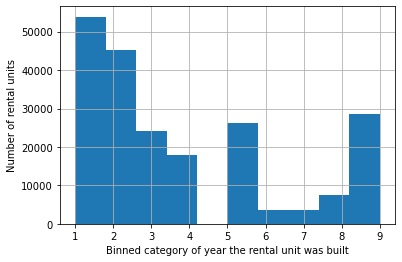

In [54]:
_= rentals.yearConstructedRange.hist()
_= plt.xlabel('Binned category of year the rental unit was built')
_= plt.ylabel('Number of rental units')

- baseRentRange indicates binned base rent. Correlates directly with baseRent. Will drop this feature because it likely includes outliers.

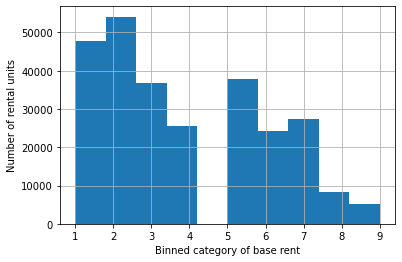

In [55]:
_= rentals.baseRentRange.hist()
_= plt.xlabel('Binned category of base rent')
_= plt.ylabel('Number of rental units')

- noRoomsRange indicates binned number of rooms 1 to 5. Redundant feature. Will drop this feature because it likely includes outliers.

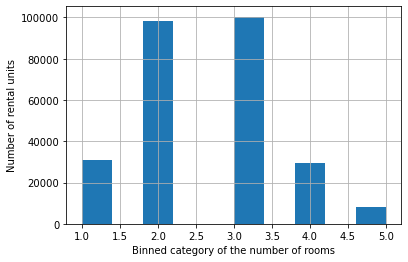

In [56]:
_= rentals.noRoomsRange.hist()
_= plt.xlabel('Binned category of the number of rooms')
_= plt.ylabel('Number of rental units')

- livingSpaceRange is the size of apartment sorted into 7 categories. Redundant feature. Will drop this feature because it likely includes outliers.

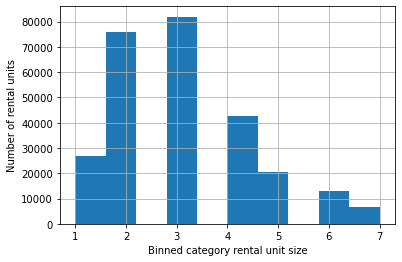

In [57]:
_= rentals.livingSpaceRange.hist()
_= plt.xlabel('Binned category rental unit size')
_= plt.ylabel('Number of rental units')

In [58]:
#Drop redundant features that may inlcude outliers
rentals.drop(columns = ['yearConstructedRange', 'baseRentRange', 'noRoomsRange', 'livingSpaceRange'], inplace = True)

In [59]:
#Verify removal of features
rentals.select_dtypes(numeric).columns

Index(['serviceCharge', 'picturecount', 'pricetrend', 'telekomUploadSpeed',
       'totalRent', 'baseRent', 'livingSpace', 'noRooms', 'thermalChar',
       'floor', 'numberOfFloors'],
      dtype='object')

## 7.3 Reviewing price-related information
### (baseRent, totalRent, serviceCharge) 

- baseRent indicates the rent without electricity or heating. Has a min value of 0 and max value of 9M euros, likely outliers.

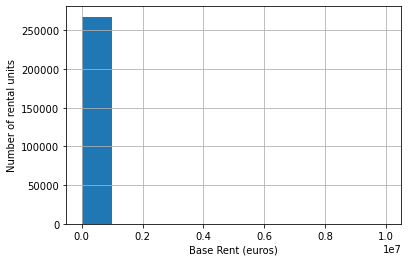

In [60]:
_= rentals.baseRent.hist()
_= plt.xlabel('Base Rent (euros)')
_= plt.ylabel('Number of rental units')

- We notice that baseRent is highly skewed to the right, likely indicating the presence of high value outliers.

In [61]:
#Define function to find limits of values
def limits(df, numerical_feature):
    q1 = df[numerical_feature].quantile(0.25)
    q3 = df[numerical_feature].quantile(0.75)
    iqr = q3 - q1
    upper_limit = q3 + (1.5 * iqr)
    lower_limit = q1 - (1.5 * iqr)
    return (lower_limit, upper_limit)

In [62]:
limits(rentals, 'baseRent')

(-354.1, 1492.46)

- Base rents above 1492.46 euros are high 

In [63]:
#Create feature with high rents
baseRent_upper = limits(rentals, 'baseRent')[1]
high_baseRent = rentals.baseRent[rentals.baseRent > baseRent_upper]

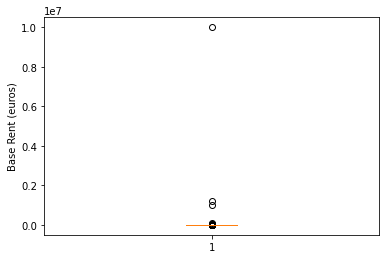

In [64]:
_= plt.boxplot(high_baseRent)
_= plt.ylabel('Base Rent (euros)')

- We notice one particular rent that is over 8M euros per month

In [65]:
#Review baseRent over 8M euros
rentals[rentals.baseRent > 8_000_000]

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,firingTypes,hasKitchen,cellar,baseRent,livingSpace,condition,lift,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,garden,regio2,regio3,date
264934,Saarland,nan,NaN,NaN,False,False,0,4.41,nan,nan,NaT,113543854,NaN,False,False,9999999.00,1.00,NaN,False,NaN,66666,1.00,nan,nan,nan,False,Merzig_Wadern_Kreis,Beckingen,2020-02-01


In [66]:
#Review rows with over 40% of their features missing
rentals[(rentals.isna().sum(axis = 1) / rentals.shape[1]) > 0.4]

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,firingTypes,hasKitchen,cellar,baseRent,livingSpace,condition,lift,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,garden,regio2,regio3,date
13881,Niedersachsen,nan,NaN,NaN,False,False,6,2.81,nan,nan,NaT,115468472,NaN,True,True,561.00,46.00,NaN,False,NaN,37085,2.00,nan,nan,nan,False,Göttingen_Kreis,Göttingen,2020-02-01
21711,Nordrhein_Westfalen,nan,NaN,NaN,False,False,8,2.73,nan,nan,NaT,115561685,NaN,False,False,775.40,145.00,NaN,False,NaN,47533,6.00,nan,nan,nan,False,Kleve_Kreis,Kleve,2020-02-01
35033,Brandenburg,nan,NaN,NaN,False,False,0,4.52,nan,nan,NaT,115267150,NaN,False,False,1.00,2.00,NaN,False,NaN,12345,99.00,nan,nan,nan,False,Teltow_Fläming_Kreis,Niedergörsdorf,2020-02-01
99510,Baden_Württemberg,nan,NaN,NaN,False,False,9,4.48,nan,nan,NaT,70597549,NaN,True,False,390.00,50.00,NaN,False,NaN,78050,2.00,nan,nan,nan,False,Schwarzwald_Baar_Kreis,Villingen_Schwenningen,2019-05-01
160522,Baden_Württemberg,nan,NaN,NaN,False,False,1,7.75,nan,nan,NaT,110653230,NaN,False,False,1300.00,76.00,NaN,False,NaN,70184,2.50,nan,nan,nan,False,Stuttgart,Ost,2019-05-01
168147,Niedersachsen,nan,NaN,NaN,False,False,0,4.82,nan,nan,NaT,77851928,NaN,False,False,1.00,1.00,NaN,False,NaN,37574,1.00,nan,nan,nan,False,Northeim_Kreis,Einbeck,2019-05-01
245256,Rheinland_Pfalz,nan,NaN,NaN,False,False,5,4.55,nan,nan,NaT,115686993,NaN,False,False,315.00,45.00,NaN,False,NaN,56566,2.00,nan,nan,nan,False,Neuwied_Kreis,Neuwied,2020-02-01
264828,Thüringen,nan,NaN,NaN,False,True,8,2.86,nan,nan,NaT,105170397,NaN,False,True,715.00,78.00,NaN,True,NaN,98527,3.00,nan,nan,nan,False,Suhl,Suhl_Mitte,2018-09-01
264934,Saarland,nan,NaN,NaN,False,False,0,4.41,nan,nan,NaT,113543854,NaN,False,False,9999999.00,1.00,NaN,False,NaN,66666,1.00,nan,nan,nan,False,Merzig_Wadern_Kreis,Beckingen,2020-02-01


- We will filter the dataframe by limiting the number of features missing to 40%

In [67]:
rentals = rentals[~((rentals.isna().sum(axis = 1) / rentals.shape[1]) > 0.4)]

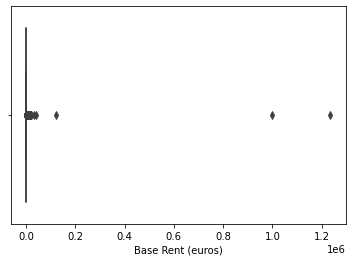

In [68]:
_= sns.boxplot(x = 'baseRent', data = rentals)
_= plt.xlabel('Base Rent (euros)')

In [69]:
#Review baseRent over 100,000 euros per month
rentals[rentals.baseRent > 100000]

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,firingTypes,hasKitchen,cellar,baseRent,livingSpace,condition,lift,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,garden,regio2,regio3,date
8406,Baden_Württemberg,nan,NaN,ONE_YEAR_FREE,False,True,13,3.90,5.00,1234567.00,NaT,107360251,NaN,True,False,1234567.00,76.00,NaN,False,apartment,68789,4.00,nan,nan,nan,False,Rhein_Neckar_Kreis,Sankt_Leon_Rot,2018-09-01
243713,Nordrhein_Westfalen,25000.00,floor_heating,ONE_YEAR_FREE,False,True,12,3.61,40.00,nan,1984-01-01,111426318,electricity,False,True,120000.00,14000.00,well_kept,False,apartment,45133,3.50,58.60,1.00,nan,False,Essen,Bredeney,2019-05-01
260259,Sachsen_Anhalt,nan,NaN,NaN,False,False,1,2.22,nan,1000000.00,NaT,91194882,NaN,False,False,1000000.00,10.00,NaN,False,other,39624,1.00,nan,nan,nan,False,Altmarkkreis_Salzwedel,Güssefeld,2019-05-01


- We notice a unit priced at 1M euro with 1 room and size 10 m^2. Such a price is unrealistic for such a unit. We will remove this.

In [70]:
rentals = rentals[~(rentals.scoutId == 91194882)]

- totalRent includes baseRent, serviceCharge and heatingCosts. Determined ~ 15% of its values to be missing. Has min value of 0 euros and max value of 15,751,540 euros. Min and max values are extreme for rents.


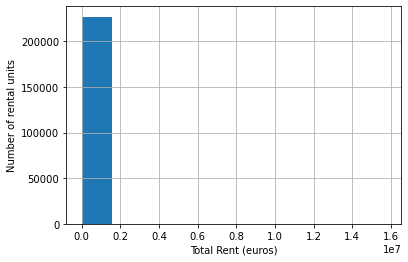

In [71]:
_= rentals.totalRent.hist()
_= plt.xlabel('Total Rent (euros)')
_= plt.ylabel('Number of rental units')

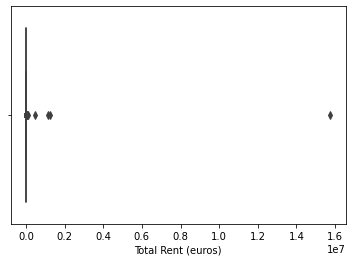

In [72]:
_= sns.boxplot(x = 'totalRent', data = rentals)
_= plt.xlabel('Total Rent (euros)')

In [73]:
#Determine ideal upper and lower bounds for totalRent if totalRent was normally distributed
limits(rentals, 'totalRent')

(-304.0, 1760.0)

In [74]:
#Review totalRent over 1M euros
rentals[rentals.totalRent > 1_000_000]

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,firingTypes,hasKitchen,cellar,baseRent,livingSpace,condition,lift,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,garden,regio2,regio3,date
8406,Baden_Württemberg,nan,NaN,ONE_YEAR_FREE,False,True,13,3.90,5.00,1234567.00,NaT,107360251,NaN,True,False,1234567.00,76.00,NaN,False,apartment,68789,4.00,nan,nan,nan,False,Rhein_Neckar_Kreis,Sankt_Leon_Rot,2018-09-01
109047,Baden_Württemberg,200.00,central_heating,ONE_YEAR_FREE,False,True,13,4.98,40.00,1150900.00,NaT,64355043,oil,False,False,950.00,137.00,refurbished,False,apartment,72644,5.00,nan,2.00,2.00,True,Esslingen_Kreis,Oberboihingen,2020-02-01
239533,Rheinland_Pfalz,250.00,combined_heat_and_power_plant,ONE_YEAR_FREE,False,True,16,4.66,40.00,15751535.00,2014-01-01,83412744,gas,False,True,1325.00,125.00,mint_condition,True,apartment,67434,3.00,56.00,2.00,3.00,False,Neustadt_an_der_Weinstraße,Kernstadt,2019-10-01


- scoutId 83412744 has a baseRent of 1325 euros and totalRent of 15,751,535 euros
- scoutId 64355043 has a baseRent of 950 and totalRent of 1,150,900 euros
- scoutId 107360251 has the same baseRent and totalRent of 1234567 which is a number sequence
- We suspect these values to be incorrect. We will remove them from the dataframe

In [75]:
rentals = rentals[~(rentals.totalRent > 1000000)]

- serviceCharge indicates ancillary costs such as electricity or internet. Previously determined that 2.6% of its values are missing. Has a min value of 0 euros and max value of 146,118.0 euros. These may be wrong data.


- Furthermore, we need to determine which values have a 0 and missing entry for both baseRent and totalRent. These don't provide information. 

In [76]:
#Units missing both baseRent and totalRent
missing_rent_filter = (((rentals.baseRent == 0) & (rentals.totalRent == 0)) | ((rentals.baseRent == 0) & (rentals.totalRent.isna())))
missing_rent = rentals.loc[missing_rent_filter, ['scoutId', 'livingSpace', 'baseRent', 'totalRent', 'noRooms', 'typeOfFlat']]
missing_rent

,scoutId,livingSpace,baseRent,totalRent,noRooms,typeOfFlat
201,108372054,45.34,0.00,nan,2.00,apartment
11130,112047388,20.00,0.00,nan,1.00,apartment
18433,104445035,0.00,0.00,nan,2.00,NaN
23721,109421874,30.00,0.00,nan,1.50,ground_floor
28965,90185228,63.00,0.00,nan,3.00,penthouse
35630,115390459,0.00,0.00,0.00,3.50,apartment
40629,106939541,0.00,0.00,nan,3.00,apartment
50683,114935600,1717.74,0.00,nan,5.00,apartment
69577,109966307,0.00,0.00,0.00,1.00,other
69778,114153004,175.00,0.00,nan,4.50,loft


In [77]:
#Remove units without rent information
rentals = rentals[~missing_rent_filter]

In [78]:
rentals.shape

(267429, 29)

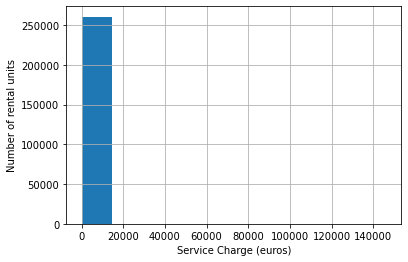

In [79]:
_= rentals.serviceCharge.hist()
_= plt.xlabel('Service Charge (euros)')
_= plt.ylabel('Number of rental units')

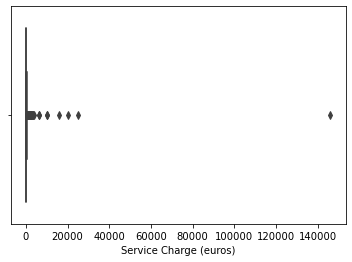

In [80]:
_= sns.boxplot(x = 'serviceCharge', data = rentals)
_= plt.xlabel('Service Charge (euros)')

In [81]:
#Determine ideal upper and lower bounds for serviceCharge if serviceCharge was normally distributed
limits(rentals, 'serviceCharge')

(-47.5, 332.5)

In [82]:
#Review serviceCharge over 10,000 euros
rentals[rentals.serviceCharge > 10_000]

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,firingTypes,hasKitchen,cellar,baseRent,livingSpace,condition,lift,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,garden,regio2,regio3,date
25687,Nordrhein_Westfalen,146118.00,self_contained_central_heating,NaN,False,False,6,4.74,nan,794.29,1928-01-01,110967960,gas,False,True,648.29,117.87,modernized,False,apartment,44809,3.00,147.00,1.00,nan,False,Bochum,Hamme,2019-05-01
144897,Nordrhein_Westfalen,20392.00,central_heating,ONE_YEAR_FREE,False,True,9,5.17,40.00,530.00,2013-01-01,69350676,gas,False,True,346.08,65.27,well_kept,True,ground_floor,32549,2.00,55.50,0.00,2.00,True,Minden_Lübbecke_Kreis,Bad_Oeynhausen,2020-02-01
153825,Sachsen,15750.00,floor_heating,NaN,True,True,6,1.53,nan,732.00,2018-01-01,103439517,district_heating,False,True,567.00,63.00,first_time_use,True,ground_floor,1237,2.00,33.60,0.00,4.00,True,Dresden,Reick,2018-09-01
178325,Sachsen_Anhalt,10038.00,district_heating,ONE_YEAR_FREE,False,False,11,2.48,40.00,341.28,1909-01-01,109786490,district_heating,False,False,240.90,40.15,modernized,False,NaN,39576,1.00,134.00,1.00,3.00,False,Stendal_Kreis,Stendal,2020-02-01
243713,Nordrhein_Westfalen,25000.00,floor_heating,ONE_YEAR_FREE,False,True,12,3.61,40.00,nan,1984-01-01,111426318,electricity,False,True,120000.00,14000.00,well_kept,False,apartment,45133,3.50,58.60,1.00,nan,False,Essen,Bredeney,2019-05-01


- We notice that in four of the five cases serviceCharge is greater than totalRent. Typically serviceCharge is included in totalRent. We will remove these rows.

In [83]:
#Remove serviceCharge features over 10,000 euros with values greater than totalRent
rentals = rentals[~((rentals.scoutId == 69350676) | (rentals.scoutId == 103439517) | (rentals.scoutId == 109786490) | (rentals.scoutId == 110967960))]

## Review Other Numeric Features
## 7.4 picturecount 

- picturecount indicates how many pictures were loaded to the listing. Min of 0 and max of 121 makes sense. 


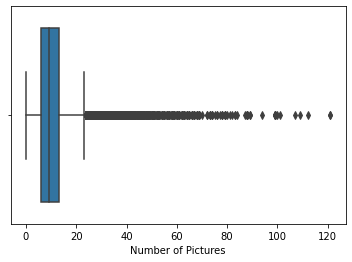

In [84]:
_= sns.boxplot(x = 'picturecount', data = rentals)
_= plt.xlabel('Number of Pictures')

## 7.5 pricetrend 

- pricetrend is a parameter calculated by immoscout. Calculation or metric was not provided, however, it likely indicates the percentage change in price for that apartment or similar apartments in the area. Observed that ~ 0.7% of its values are missing. Has a min value of -12 and max value of 14.9. Range seems reasonable at first glance.


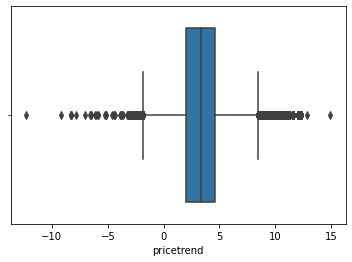

In [85]:
_= sns.boxplot(x = 'pricetrend', data = rentals)
_= plt.xlabel('pricetrend')

## 7.6 telekomUploadSpeed 

- telekomUploadSpeed indicates internet upload speed. Determined that 12.4% of its values are missing. Unit not provided, but is typically measured in Mbps. Has seven values, with min speed of 1 and max speed of 100. Range seems reasonable at first glance. 


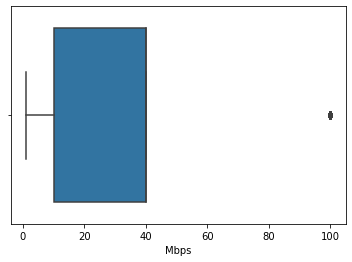

In [86]:
_= sns.boxplot(x = 'telekomUploadSpeed', data = rentals)
_= plt.xlabel('Mbps')

## 7.7 livingSpace 

- livingSpace indicates living space in sqm. Min value of 0 and max value of 110,000 sqm, likely outliers.


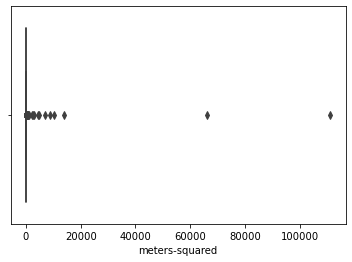

In [87]:
_= sns.boxplot(x = 'livingSpace', data = rentals)
_= plt.xlabel('meters-squared')

In [88]:
#Determine ideal upper and lower bounds for livingSpace if livingSpace was normally distributed
limits(rentals, 'livingSpace')

(4.5, 136.5)

In [89]:
#Review livingSpace over 10,000 sq.m
rentals[rentals.livingSpace > 10_000]

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,firingTypes,hasKitchen,cellar,baseRent,livingSpace,condition,lift,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,garden,regio2,regio3,date
151184,Bayern,115.00,central_heating,ONE_YEAR_FREE,False,False,23,6.09,40.00,1400.00,1987-01-01,109350573,oil,False,True,1200.00,66100.00,well_kept,False,roof_storey,81737,2.00,110.00,2.00,3.00,True,München,Perlach,2019-05-01
175397,Sachsen_Anhalt,nan,NaN,NaN,False,False,0,4.61,nan,369.00,NaT,113363197,NaN,False,False,679.00,111111.00,NaN,False,apartment,39624,3.00,nan,nan,nan,False,Altmarkkreis_Salzwedel,Güssefeld,2019-10-01
223187,Hessen,128.25,district_heating,ONE_YEAR_FREE,False,True,11,6.17,2.40,1641.50,2016-01-01,109754861,district_heating,True,True,1385.00,10259.00,mint_condition,True,apartment,60435,3.00,22.45,1.00,4.00,True,Frankfurt_am_Main,Preungesheim,2019-05-01
243713,Nordrhein_Westfalen,25000.00,floor_heating,ONE_YEAR_FREE,False,True,12,3.61,40.00,nan,1984-01-01,111426318,electricity,False,True,120000.00,14000.00,well_kept,False,apartment,45133,3.50,58.60,1.00,nan,False,Essen,Bredeney,2019-05-01


- The one unit that seems out of place has a size of 111,111 sq.m. The format of the value indicates an error. Furthermore, the tallest hotel in germany has a floor space of 109,200 sq.m which is less than this value. We will remove this entry.  

In [90]:
rentals = rentals[~(rentals.scoutId == 113363197)]

In [91]:
#Review livingSpace over 1,000 sq.m
rentals.loc[rentals.livingSpace > 1_000, ['scoutId', 'livingSpace', 'baseRent', 'totalRent', 'noRooms', 'typeOfFlat']]

,scoutId,livingSpace,baseRent,totalRent,noRooms,typeOfFlat
51540,109860941,8684.00,504.00,650.00,3.00,NaN
92451,110383735,2257.88,800.00,nan,75.50,NaN
151184,109350573,66100.00,1200.00,1400.00,2.00,roof_storey
172399,111349875,4340.00,200.00,260.00,2.00,apartment
202205,112281127,7008.00,519.00,nan,3.00,apartment
215900,111330060,2782.00,245.00,nan,3.00,ground_floor
222457,113860387,2420.00,283.14,nan,1.00,apartment
223187,109754861,10259.00,1385.00,1641.50,3.00,apartment
229248,63845567,4947.00,200.00,nan,2.00,ground_floor
243713,111426318,14000.00,120000.00,nan,3.50,apartment


## 7.8 noRooms 

- noRooms indicates number of rooms in apartment. Min value of 1. Max value of 999, likely an outlier. 

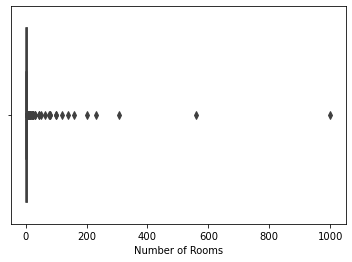

In [92]:
_= sns.boxplot(x = 'noRooms', data = rentals)
_= plt.xlabel('Number of Rooms')

- We notice units having more than 100 rooms.

In [93]:
#Determine ideal upper and lower bounds for noRooms if livingSpace was normally distributed
limits(rentals, 'noRooms')

(0.5, 4.5)

In [94]:
#Review noRooms over 10 and size less than 100 sq.m (size of a parking space)
rentals.loc[(rentals.noRooms > 10) & (rentals.livingSpace < 100), ['livingSpace', 'noRooms', 'typeOfFlat']]

,livingSpace,noRooms,typeOfFlat
5206,3.00,99.50,apartment
17897,57.00,200.00,apartment
18961,14.00,140.00,other
43563,79.00,25.00,NaN
52202,60.00,22.00,NaN
70070,45.00,25.00,roof_storey
77343,50.00,50.00,NaN
88504,37.01,12.00,ground_floor
93113,48.00,15.00,roof_storey
98055,80.00,80.00,apartment


- These are clearly mistakes. We will remove these rows

In [95]:
rentals = rentals [~((rentals.noRooms > 10) & (rentals.livingSpace < 100))]

In [96]:
rentals.shape

(267401, 29)

## 7.9 thermalChar 

- thermalChar indicates energy demand of apartment. Data owner noted that it is used to determine energyEfficiencyClass. Has unit - kWh/(m^2a) [Kilowatt per square meter per annum] Determined that ~ 40% of its values are missing. Has a min value of 0.1 and max value of 1996. Values seem extreme. 


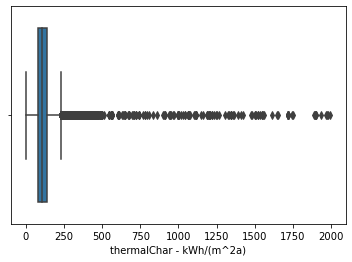

In [97]:
_= sns.boxplot(x = 'thermalChar', data = rentals)
_= plt.xlabel('thermalChar - kWh/(m^2a)')

In [98]:
#Determine ideal upper and lower bounds for thermalChar if thermalChar was normally distributed
limits(rentals, 'thermalChar')

(-12.5, 231.5)

In [99]:
#Determine if there are rows where thermalChar is equivalent to yearConstructed
rentals[rentals.thermalChar == rentals.yearConstructed.dt.year]

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,firingTypes,hasKitchen,cellar,baseRent,livingSpace,condition,lift,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,garden,regio2,regio3,date
57965,Sachsen_Anhalt,74.00,NaN,ONE_YEAR_FREE,False,True,10,2.13,40.00,480.00,1974-01-01,113050356,district_heating,False,True,308.00,61.03,well_kept,False,apartment,6128,3.00,1974.00,4.00,4.00,False,Halle_Saale,Südstadt,2020-02-01
123270,Sachsen,134.00,district_heating,ONE_YEAR_FREE,False,False,3,0.20,40.00,508.00,1983-01-01,111202052,district_heating,False,False,374.00,67.00,NaN,True,NaN,9123,2.00,1983.00,1.00,nan,False,Chemnitz,Markersdorf,2019-05-01
204426,Sachsen,78.00,NaN,ONE_YEAR_FREE,False,False,10,0.36,40.00,251.00,1897-01-01,112262263,gas,False,False,173.00,35.38,NaN,False,ground_floor,9116,1.00,1897.00,0.00,nan,False,Chemnitz,Altendorf,2019-10-01
262421,Sachsen,78.00,NaN,ONE_YEAR_FREE,False,False,9,0.54,40.00,251.00,1897-01-01,115006851,gas,False,True,173.00,35.38,NaN,False,ground_floor,9116,1.00,1897.00,0.00,nan,False,Chemnitz,Altendorf,2020-02-01


- There are 4 rows where thermalChar is equivalent to yearConstructed, which suggests an error.

In [100]:
#Remove rows where thermalChar is equivalent to yearConstructed
rentals = rentals[~(rentals.thermalChar == rentals.yearConstructed.dt.year)]

In [101]:
rentals.shape

(267397, 29)

## 7.10 floor and numberOfFloors

- floor indicates floor number of apartment. Determined that 19% of its values are missing. Has 53 unique values, with min of -1 and max of 999. Min of -1 likely indicates a basement apartment, but a max of 999 is an extreme value. Floor number is an identifier for the apartment specific to the building.
- numberOfFloors indicates the number of floors in the building. Has 57 unique values, with min of 0 and max of 999, similar to 'floor'. 999 is an extreme values.

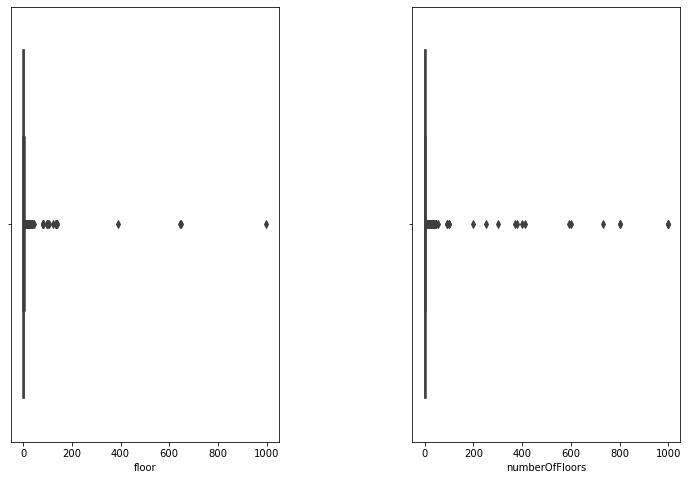

In [102]:
fig, ax = plt.subplots(nrows = 1,ncols = 2, figsize=(12, 8))
_= sns.boxplot(x = 'floor', data = rentals, ax = ax[0])
_= sns.boxplot(x = 'numberOfFloors', data = rentals, ax = ax[1])
plt.subplots_adjust(wspace= 0.5)
plt.show()

In [103]:
#Determine ideal upper and lower bounds for floor and numberOfFloors if they were normally distributed
limits(rentals, 'floor'), limits(rentals,'numberOfFloors')

((-2.0, 6.0), (-1.0, 7.0))

- Tallest German building has 56 floors. We will filter with this limit. Also we note that the numberOfFloors provides a relates better to price than the number of the floor. We will drop floor.

In [104]:
#Drop floor
rentals.drop('floor', axis =1, inplace = True)

In [105]:
#Review rows with number of floors greater than 56
rentals[rentals.numberOfFloors > 56]

,regio1,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,firingTypes,hasKitchen,cellar,baseRent,livingSpace,condition,lift,typeOfFlat,geo_plz,noRooms,thermalChar,numberOfFloors,garden,regio2,regio3,date
26590,Baden_Württemberg,nan,district_heating,ONE_YEAR_FREE,False,False,7,4.17,40.00,nan,NaT,94763921,district_heating,True,False,570.00,40.00,well_kept,False,roof_storey,68165,1.50,143.00,90.00,False,Mannheim,Schwetzingerstadt_/_Oststadt,2018-09-01
35220,Nordrhein_Westfalen,56.00,night_storage_heater,ONE_YEAR_FREE,False,False,5,2.07,40.00,2.00,NaT,83599326,electricity,False,False,245.00,44.20,well_kept,False,other,45888,1.50,nan,301.00,False,Gelsenkirchen,Bulmke_Hüllen,2020-02-01
43275,Sachsen_Anhalt,132.00,district_heating,ONE_YEAR_FREE,False,True,7,1.85,40.00,512.00,1935-01-01,104185905,district_heating,True,True,378.00,61.00,fully_renovated,False,apartment,39576,2.00,83.90,378.00,True,Stendal_Kreis,Stendal,2018-09-01
48498,Bayern,120.00,central_heating,ONE_YEAR_FREE,False,True,11,4.31,40.00,720.00,1976-01-01,113684019,oil,True,True,600.00,50.00,mint_condition,False,apartment,83346,2.00,nan,999.00,False,Traunstein_Kreis,Bergen,2019-10-01
64453,Rheinland_Pfalz,120.00,floor_heating,ONE_YEAR_FREE,False,True,5,4.36,2.40,620.00,1982-01-01,113850887,district_heating,True,True,500.00,92.00,well_kept,False,raised_ground_floor,56736,2.50,nan,92.00,True,Mayen_Koblenz_Kreis,Kottenheim,2019-10-01
72253,Bayern,170.00,central_heating,ONE_YEAR_FREE,False,True,6,3.74,40.00,850.00,1985-01-01,111358313,gas,False,True,680.00,69.00,mint_condition,False,ground_floor,83278,2.00,102.00,999.00,False,Traunstein_Kreis,Traunstein,2019-05-01
82112,Sachsen,120.00,central_heating,ONE_YEAR_FREE,False,True,11,1.37,40.00,4.00,1995-01-01,65507848,gas,True,True,280.00,52.50,well_kept,True,apartment,1662,1.00,79.60,400.00,False,Meißen_Kreis,Meißen,2019-10-01
100789,Hessen,110.00,central_heating,ONE_YEAR_FREE,False,True,7,4.55,40.00,nan,1973-01-01,115121989,gas,True,False,300.00,27.00,well_kept,False,other,65549,1.00,118.20,999.00,False,Limburg_Weilburg_Kreis,Limburg_an_der_Lahn,2020-02-01
107377,Nordrhein_Westfalen,120.00,oil_heating,ONE_YEAR_FREE,False,True,1,3.60,2.40,680.00,NaT,115429800,NaN,True,True,560.00,75.00,NaN,False,roof_storey,42555,2.00,nan,800.00,False,Mettmann_Kreis,Velbert,2020-02-01
123333,Niedersachsen,110.00,central_heating,ONE_YEAR_FREE,False,True,17,5.08,40.00,nan,1954-01-01,104361657,gas,True,False,399.00,73.00,well_kept,True,apartment,26384,2.00,119.00,594.00,False,Wilhelmshaven,Heppens,2018-09-01


In [106]:
#We will drop rows with number of floors > 56
rentals = rentals[~(rentals.numberOfFloors > 56)]

In [107]:
rentals.shape

(267378, 28)

In [108]:
rentals.select_dtypes('boolean').columns

Index(['newlyConst', 'balcony', 'hasKitchen', 'cellar', 'lift', 'garden'], dtype='object')

# 8. Review of Boolean Features

In [109]:
rentals.select_dtypes('boolean').head()

,newlyConst,balcony,hasKitchen,cellar,lift,garden
0,False,False,False,True,False,True
1,False,True,False,False,False,False
2,True,True,False,True,True,False
3,False,True,False,False,False,False
4,False,True,False,False,False,False


# 9. Saving New Dataframe

In [111]:
datapath = 'C:\\Users\\zebin\\OneDrive\\Documents\\Education\\Data Science\\Springboard - Data Science\\Capstones\\Capstone_2\\german_apartment_rentals\\data\\processed'
# renaming the output data directory and re-running this notebook, for example,
# will recreate this (empty) directory and resave the data files.
# NB this is not a substitute for a modern data pipeline, for which there are
# various tools. However, for our purposes here, and often in a "one off" analysis,
# this is useful because we have to deliberately move/delete our data in order
# to overwrite it.
if not os.path.exists(datapath):
    os.mkdir(datapath)

In [112]:
datapath_rentals = os.path.join(datapath, 'rentals_cleaned2.csv')
if not os.path.exists(datapath_rentals):
    rentals.to_csv(datapath_rentals, index=False)